In [26]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from hyperparameters import *
from constants import *
import matplotlib.ticker as ticker

In [27]:
def plot_loss_train():
    time_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    plot_train_loss_gru = torch.load('graphs/data/seq2seq_bigru_train_loss')
    train_min_value_gru = min(plot_train_loss_gru)
    train_min_index_gru = plot_train_loss_gru.index(train_min_value_gru)

    plot_train_loss_attention_gru = torch.load('graphs/data/seq2seq_attention_gru_train_loss')
    train_min_value_attention_gru = min(plot_train_loss_attention_gru)
    train_min_index_attention_gru = plot_train_loss_attention_gru.index(train_min_value_attention_gru)

    plot_train_loss_transformer = torch.load('graphs/data/transformer_train_loss')
    train_min_value_transformer = min(plot_train_loss_transformer)
    train_min_index_transformer = plot_train_loss_transformer.index(train_min_value_transformer)


    plt.title('Average train loss per epoch of 3 models')
    plt.plot(plot_train_loss_gru, 'r', label='GRU')
    plt.plot(train_min_index_gru, train_min_value_gru, 'ro')
    plt.annotate(f"{train_min_value_gru:.4f}", (train_min_index_gru, train_min_value_gru), verticalalignment='top')

    plt.plot(plot_train_loss_attention_gru, 'g', label='Attention')
    plt.plot(train_min_index_attention_gru, train_min_value_attention_gru, 'go')
    plt.annotate(f"{train_min_value_attention_gru:.4f}", (train_min_index_attention_gru, train_min_value_attention_gru), verticalalignment='top')

    plt.plot(plot_train_loss_transformer, 'b', label='Transformer')
    plt.plot(train_min_index_transformer, train_min_value_transformer, 'bo')
    plt.annotate(f"{train_min_value_transformer:.4f}", (train_min_index_transformer, train_min_value_transformer), verticalalignment='top')


    plt.xlabel('Number of Epochs')
    plt.ylabel('Average loss')
    plt.legend()
    plt.xticks(np.arange(1, len(plot_train_loss_gru)+1, 5))
    plt.savefig(f"graphs/graphs/train_loss_{time_stamp}.png")
    plt.figure().clear()

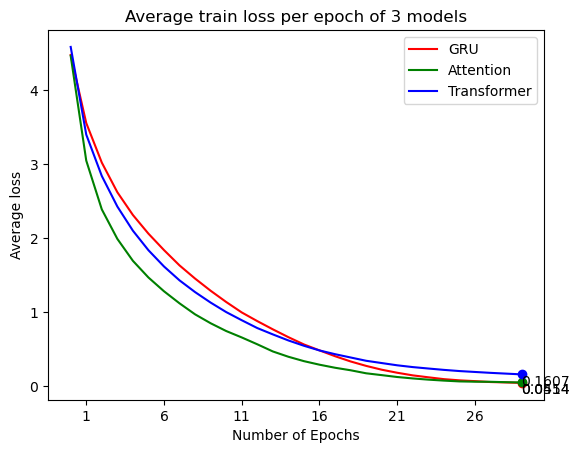

<Figure size 640x480 with 0 Axes>

In [28]:
plot_loss_train()

In [29]:
def plot_loss_dev():
    time_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    plot_dev_loss_gru = torch.load('graphs/data/seq2seq_bigru_dev_loss')
    dev_min_value_gru = min(plot_dev_loss_gru)
    dev_min_index_gru = plot_dev_loss_gru.index(dev_min_value_gru)

    plot_dev_loss_attention_gru = torch.load('graphs/data/seq2seq_attention_gru_dev_loss')
    dev_min_value_attention_gru = min(plot_dev_loss_attention_gru)
    dev_min_index_attention_gru = plot_dev_loss_attention_gru.index(dev_min_value_attention_gru)

    plot_dev_loss_transformer = torch.load('graphs/data/transformer_dev_loss')
    dev_min_value_transformer = min(plot_dev_loss_transformer)
    dev_min_index_transformer = plot_dev_loss_transformer.index(dev_min_value_transformer)


    plt.title('Average dev loss per epoch of 3 models')
    plt.plot(plot_dev_loss_gru, 'r', label='GRU')
    plt.plot(dev_min_index_gru, dev_min_value_gru, 'ro')
    plt.annotate(f"{dev_min_value_gru:.4f}", (dev_min_index_gru, dev_min_value_gru), verticalalignment='top')

    plt.plot(plot_dev_loss_attention_gru, 'g', label='Attention')
    plt.plot(dev_min_index_attention_gru, dev_min_value_attention_gru, 'go')
    plt.annotate(f"{dev_min_value_attention_gru:.4f}", (dev_min_index_attention_gru, dev_min_value_attention_gru), verticalalignment='top')

    plt.plot(plot_dev_loss_transformer, 'b', label='Transformer')
    plt.plot(dev_min_index_transformer, dev_min_value_transformer, 'bo')
    plt.annotate(f"{dev_min_value_transformer:.4f}", (dev_min_index_transformer, dev_min_value_transformer), verticalalignment='top')


    plt.xlabel('Number of Epochs')
    plt.ylabel('Average loss')
    plt.legend()
    plt.xticks(np.arange(1, len(plot_dev_loss_gru)+1, 5))
    plt.savefig(f"graphs/graphs/dev_loss_{time_stamp}.png")
    plt.figure().clear()

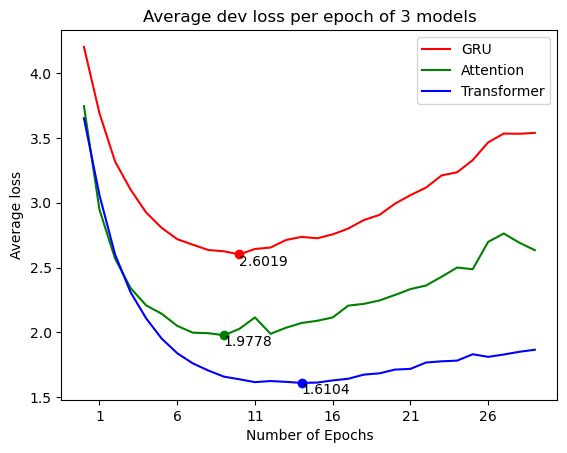

<Figure size 640x480 with 0 Axes>

In [30]:
plot_loss_dev()

In [39]:
def plot_bleu_train():
    time_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    plot_train_bleu_gru = torch.load('graphs/data/seq2seq_bigru_train_bleu')
    train_max_value_gru = max(plot_train_bleu_gru)
    train_max_index_gru = plot_train_bleu_gru.index(train_max_value_gru)

    plot_train_bleu_attention_gru = torch.load('graphs/data/seq2seq_attention_gru_train_bleu')
    train_max_value_attention_gru = max(plot_train_bleu_attention_gru)
    train_max_index_attention_gru = plot_train_bleu_attention_gru.index(train_max_value_attention_gru)

    plot_train_bleu_transformer = torch.load('graphs/data/transformer_train_bleu')
    train_max_value_transformer = max(plot_train_bleu_transformer)
    train_max_index_transformer = plot_train_bleu_transformer.index(train_max_value_transformer)


    plt.title('Average train bleu score per epoch of 3 models')
    plt.plot(plot_train_bleu_gru, 'r', label='GRU')
    plt.plot(train_max_index_gru, train_max_value_gru, 'ro')
    plt.annotate(f"{train_max_value_gru:.4f}", (train_max_index_gru, train_max_value_gru), verticalalignment='top')

    plt.plot(plot_train_bleu_attention_gru, 'g', label='Attention')
    plt.plot(train_max_index_attention_gru, train_max_value_attention_gru, 'go')
    plt.annotate(f"{train_max_value_attention_gru:.4f}", (train_max_index_attention_gru, train_max_value_attention_gru), verticalalignment='top')

    plt.plot(plot_train_bleu_transformer, 'b', label='Transformer')
    plt.plot(train_max_index_transformer, train_max_value_transformer, 'bo')
    plt.annotate(f"{train_max_value_transformer:.4f}", (train_max_index_transformer, train_max_value_transformer), verticalalignment='top')


    plt.xlabel('Number of Epochs')
    plt.ylabel('Average bleu score')
    plt.legend()
    plt.xticks(np.arange(1, len(plot_train_bleu_gru)+1, 5))
    plt.savefig(f"graphs/graphs/train_bleu_{time_stamp}.png")
    plt.figure().clear()

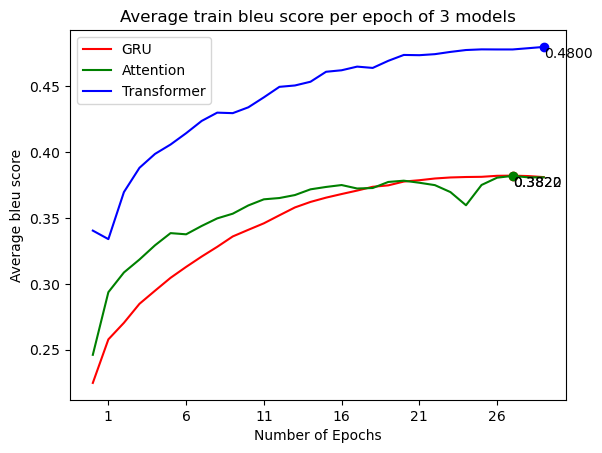

<Figure size 640x480 with 0 Axes>

In [40]:
plot_bleu_train()

In [33]:
def plot_bleu_dev():
    time_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    plot_dev_bleu_gru = torch.load('graphs/data/seq2seq_bigru_dev_bleu')
    train_max_value_gru = max(plot_dev_bleu_gru)
    train_max_index_gru = plot_dev_bleu_gru.index(train_max_value_gru)

    plot_dev_bleu_attention_gru = torch.load('graphs/data/seq2seq_attention_gru_dev_bleu')
    train_max_value_attention_gru = max(plot_dev_bleu_attention_gru)
    train_max_index_attention_gru = plot_dev_bleu_attention_gru.index(train_max_value_attention_gru)

    plot_dev_bleu_transformer = torch.load('graphs/data/transformer_dev_bleu')
    train_max_value_transformer = max(plot_dev_bleu_transformer)
    train_max_index_transformer = plot_dev_bleu_transformer.index(train_max_value_transformer)


    plt.title('Average dev bleu score per epoch of 3 models')
    
    plt.plot(plot_dev_bleu_gru, 'r', label='GRU')
    plt.plot(train_max_index_gru, train_max_value_gru, 'ro')
    plt.annotate(f"{train_max_value_gru:.4f}", (train_max_index_gru, train_max_value_gru), verticalalignment='top')

    plt.plot(plot_dev_bleu_attention_gru, 'g', label='Attention')
    plt.plot(train_max_index_attention_gru, train_max_value_attention_gru, 'go')
    plt.annotate(f"{train_max_value_attention_gru:.4f}", (train_max_index_attention_gru, train_max_value_attention_gru), verticalalignment='top')

    plt.plot(plot_dev_bleu_transformer, 'b', label='Transformer')
    plt.plot(train_max_index_transformer, train_max_value_transformer, 'bo')
    plt.annotate(f"{train_max_value_transformer:.4f}", (train_max_index_transformer, train_max_value_transformer), verticalalignment='top')


    plt.xlabel('Number of Epochs')
    plt.ylabel('Average bleu score')
    plt.legend()
    plt.xticks(np.arange(1, len(plot_dev_bleu_gru)+1, 5))
    plt.savefig(f"graphs/graphs/dev_bleu_{time_stamp}.png")
    plt.figure().clear()

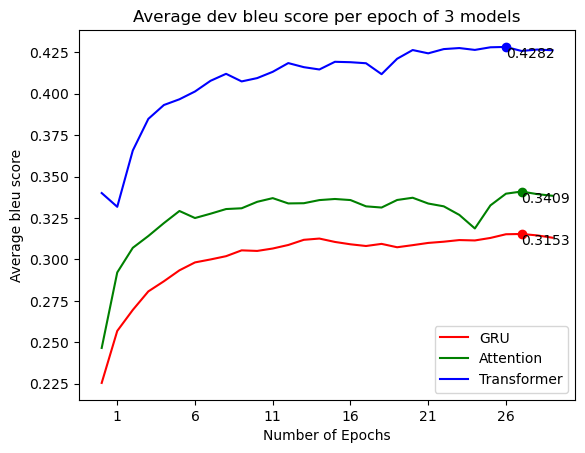

<Figure size 640x480 with 0 Axes>

In [34]:
plot_bleu_dev()

In [67]:
def plot_bleu_per_sentence():
    time_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    bleu_per_sentence_gru = torch.load(f'graphs/data/bleu_per_sentences_seq2seq_bigru')
    bleu_per_sentence_attention_gru = torch.load(f'graphs/data/bleu_per_sentences_seq2seq_attention_gru')
    bleu_per_sentence_transformer = torch.load(f'graphs/data/bleu_per_sentences_transformer')

    input_lengths = torch.load(f"graphs/data/inputs_length")
   
    
    plot_bleu_per_sentence_gru = []
    plot_bleu_per_sentence_attention_gru = []
    plot_bleu_per_sentence_transformer = []
    plot_input_lengths = []

    for i in range(len(input_lengths)):
        if input_lengths[i] not in plot_input_lengths:
            plot_bleu_per_sentence_gru.append(bleu_per_sentence_gru[i])
            plot_bleu_per_sentence_attention_gru.append(bleu_per_sentence_attention_gru[i])
            plot_bleu_per_sentence_transformer.append(bleu_per_sentence_transformer[i])
            plot_input_lengths.append(input_lengths[i])

    index = np.argsort(plot_input_lengths)
    plot_bleu_per_sentence_gru = np.array(plot_bleu_per_sentence_gru)[index]
    plot_bleu_per_sentence_attention_gru = np.array(plot_bleu_per_sentence_attention_gru)[index]
    plot_bleu_per_sentence_transformer = np.array(plot_bleu_per_sentence_transformer)[index]
    plot_input_lengths = np.sort(plot_input_lengths)

    plt.figure(figsize=(10, 6))
    plt.title('Bleu score on sentences of 3 models')
    plt.bar(plot_input_lengths - 0.2, plot_bleu_per_sentence_gru, width=0.2, label="GRU")
    plt.bar(plot_input_lengths, plot_bleu_per_sentence_attention_gru, width=0.2, label="Attention")
    plt.bar(plot_input_lengths + 0.2, plot_bleu_per_sentence_transformer, width=0.2, label="Transformer")
    plt.xticks(plot_input_lengths)
    plt.legend()
    plt.xlabel("Sentence's length")
    plt.ylabel('Bleu Score')

    plt.savefig(f"graphs/graphs/bleu_per_sentence_{time_stamp}.png")
    plt.figure().clear()

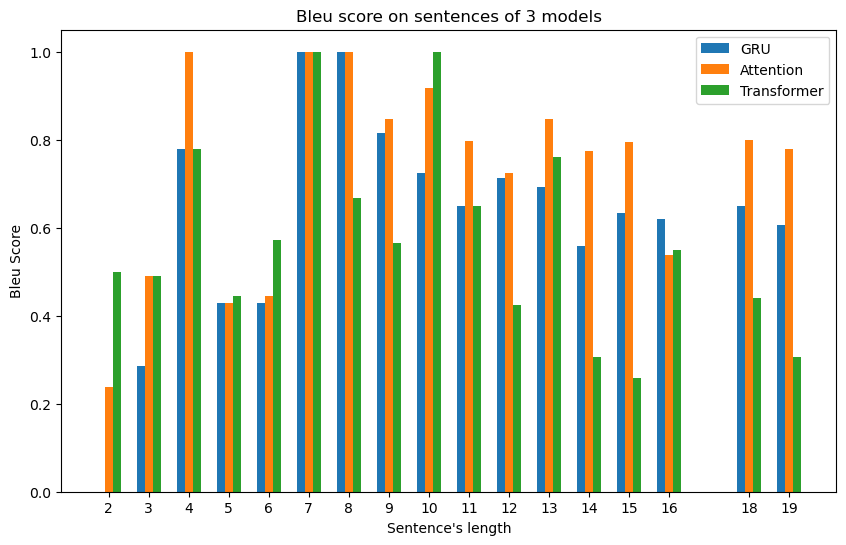

<Figure size 640x480 with 0 Axes>

In [68]:
plot_bleu_per_sentence()